# Exploring Transaction Annotations (15M, 2026-02-07)

New data drop: `/home/armin/datalake/data-samples/tx-annotations-15m-2-7-2026.pkl`

**15M Bitcoin transactions** with structural labels and tags.

### Data sources

| Source | Rows | Key | Notes |
|--------|------|-----|-------|
| **Annotations** (new) | 14,984,540 | `tx_id` | labels, tags, structural features |
| **Data-lake DB** (original) | 14,984,540 | `tx_id` | 100% match — raw mempool data |
| **mempool_space_data.db** (corrected) | 19,065,494 | `txid` | 99.4% match — corrected weight/fee_rate |

In [14]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 120, "figure.figsize": (12, 5)})

ANNOT_PATH = "/home/armin/datalake/data-samples/tx-annotations-15m-2-7-2026.pkl"
LAKE_DB = "/home/armin/datalake/data-samples/11-24-2025-15m-data-lake.db"
MEMPOOL_DB = "/home/kristian/notebooks/mempool_space_data.db"

## 1. Load & Inspect Annotations

In [15]:
annot = pd.read_pickle(ANNOT_PATH)
print(f"Shape: {annot.shape}")
print(f"Columns: {list(annot.columns)}")
print(f"\nDtypes:\n{annot.dtypes}")
annot.head()

Shape: (14984540, 9)
Columns: ['label', 'tags', 'n_in', 'n_out', 'max_equal_group', 'unique_out_values', 'tolerance_sats', 'tx_id', '_error']

Dtypes:
label                object
tags                 object
n_in                  int64
n_out                 int64
max_equal_group       int64
unique_out_values     int64
tolerance_sats        int64
tx_id                object
_error               object
dtype: object


,label,tags,n_in,n_out,max_equal_group,unique_out_values,tolerance_sats,tx_id,_error
0,datacarrying,[inscription],1,2,1,2,1000,0000000e80cafb5569e05c6dd70db194611327873b7282...,NaN
1,normal,[],1,1,1,1,1000,000000101551d29c0cf430d9d5ab84f15b94ba09d5c434...,NaN
2,normal,[],1,1,1,1,1000,00000010b5e4595d9e38eaab34620141285c8400392cf2...,NaN
3,normal,[],1,1,1,1,1000,00000010d2f063d0e622af41c5e91b772545d96cc3f562...,NaN
4,normal,[],1,1,1,1,1000,00000011c890196ba17accb2aa239efada327ac7f2765e...,NaN


In [16]:
annot.describe()

,n_in,n_out,max_equal_group,unique_out_values,tolerance_sats
count,1.498454e+07,1.498454e+07,1.498454e+07,1.498454e+07,14984540.0
mean,2.461930e+00,2.691275e+00,1.265847e+00,2.543098e+00,1000.0
std,1.894550e+01,1.042760e+01,4.115165e+00,8.392817e+00,0.0
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1000.0
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1000.0
50%,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1000.0
75%,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1000.0
max,1.726000e+03,2.240000e+03,2.239000e+03,1.862000e+03,1000.0


In [17]:
# Null check — only _error has nulls (just 2 rows with actual errors)
print(annot.isnull().sum())
print(f"\n_error non-null values:")
print(annot["_error"].dropna().value_counts())

label                       0
tags                        0
n_in                        0
n_out                       0
max_equal_group             0
unique_out_values           0
tolerance_sats              0
tx_id                       0
_error               14984538
dtype: int64

_error non-null values:
_error
Server disconnected without sending a response.    1
                                                   1
Name: count, dtype: int64


## 2. Label Distribution

In [18]:
label_counts = annot["label"].value_counts()
label_pct = (label_counts / len(annot) * 100).round(2)
pd.DataFrame({"count": label_counts, "pct": label_pct})

,count,pct
label,,
normal,9866937,65.85
datacarrying,3527445,23.54
consolidation,1074284,7.17
batch_payment,490871,3.28
coinjoin,25001,0.17
error,2,0.00


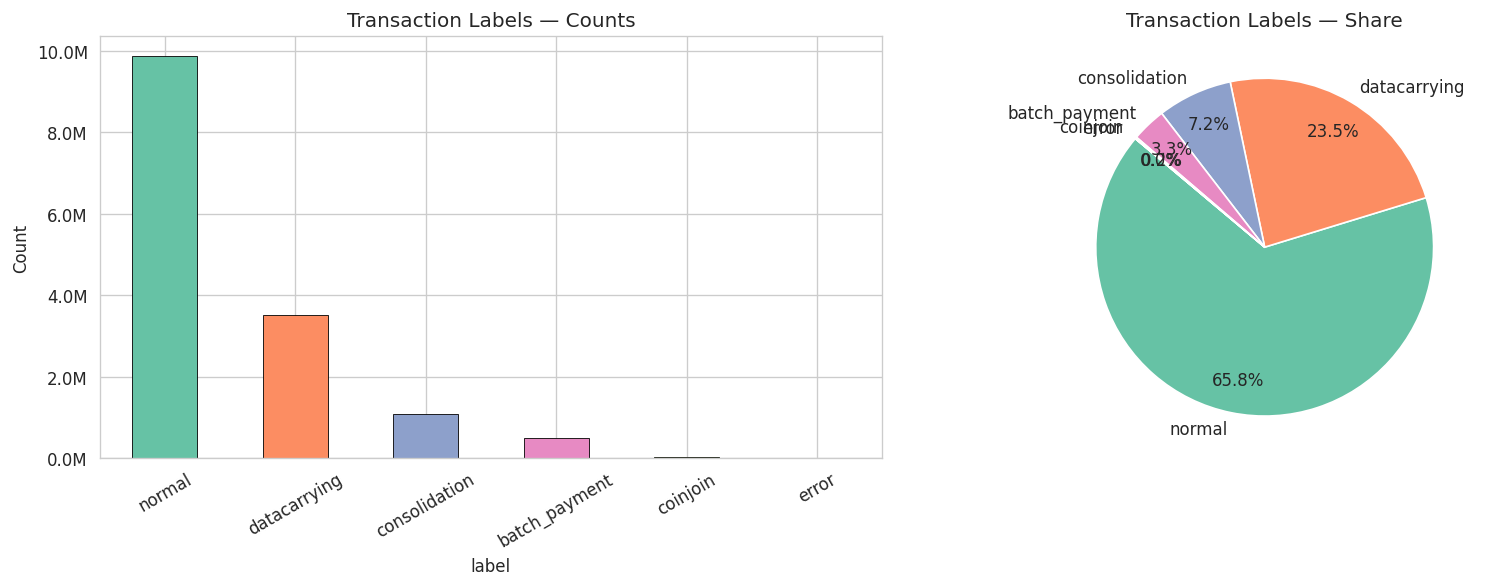

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = sns.color_palette("Set2", n_colors=len(label_counts))
label_counts.plot.bar(ax=axes[0], color=colors, edgecolor="black", linewidth=0.5)
axes[0].set_title("Transaction Labels — Counts")
axes[0].set_ylabel("Count")
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
axes[0].tick_params(axis="x", rotation=30)

label_pct_vals = label_counts / label_counts.sum() * 100
axes[1].pie(label_pct_vals, labels=label_pct_vals.index, autopct="%1.1f%%", colors=colors,
            startangle=140, pctdistance=0.8)
axes[1].set_title("Transaction Labels — Share")

plt.tight_layout()
plt.savefig("plots/tx_annotation_labels.png", bbox_inches="tight")
plt.show()

## 3. Tags Analysis

`tags` is a list column (e.g. `['op_return', 'inscription']`).

In [20]:
tag_combos = annot["tags"].apply(tuple).value_counts()
print("Top tag combinations:")
print(tag_combos.head(10))
print(f"\nWith tags:    {(annot['tags'].str.len() > 0).sum():,}")
print(f"Without tags: {(annot['tags'].str.len() == 0).sum():,}")

Top tag combinations:
tags
()                          11398779
(op_return, inscription)     1698311
(op_return,)                 1303315
(inscription,)                584135
Name: count, dtype: int64

With tags:    3,585,761
Without tags: 11,398,779


Individual tag frequencies:
tags
op_return      3001626
inscription    2282446
Name: count, dtype: int64


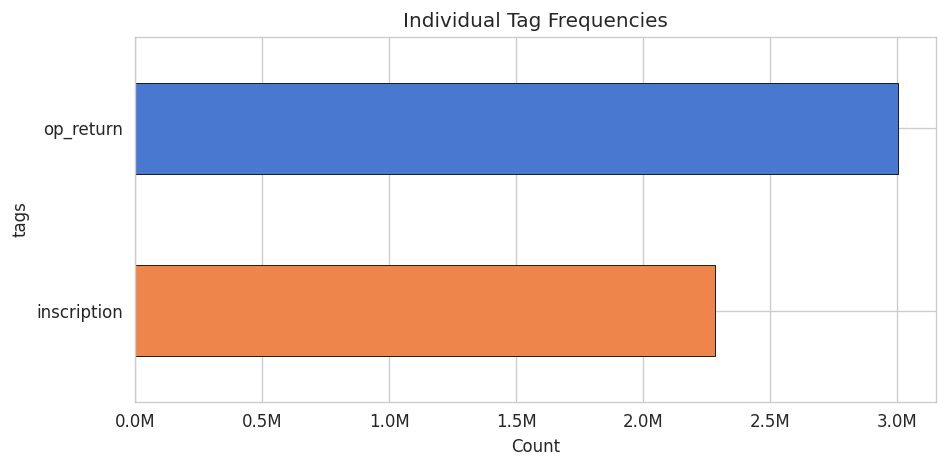

In [21]:
# Explode individual tags
all_tags = annot["tags"].explode().dropna()
all_tags = all_tags[all_tags != ""]
tag_counts = all_tags.value_counts()
print("Individual tag frequencies:")
print(tag_counts)

if len(tag_counts) > 0:
    fig, ax = plt.subplots(figsize=(8, 4))
    tag_counts.plot.barh(ax=ax, color=sns.color_palette("muted", len(tag_counts)),
                         edgecolor="black", linewidth=0.5)
    ax.set_title("Individual Tag Frequencies")
    ax.set_xlabel("Count")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

In [22]:
# Cross-tab: label vs tag flags
annot["has_op_return"] = annot["tags"].apply(lambda t: "op_return" in t)
annot["has_inscription"] = annot["tags"].apply(lambda t: "inscription" in t)

print("Label x has_op_return:")
print(pd.crosstab(annot["label"], annot["has_op_return"], margins=True))
print()
print("Label x has_inscription:")
print(pd.crosstab(annot["label"], annot["has_inscription"], margins=True))

Label x has_op_return:
has_op_return     False     True       All
label                                     
batch_payment    459027    31844    490871
coinjoin          23877     1124     25001
consolidation   1070091     4193   1074284
datacarrying     562980  2964465   3527445
error                 2        0         2
normal          9866937        0   9866937
All            11982914  3001626  14984540

Label x has_inscription:
has_inscription     False     True       All
label                                       
batch_payment      489859     1012    490871
coinjoin            24559      442     25001
consolidation     1054115    20169   1074284
datacarrying      1266622  2260823   3527445
error                   2        0         2
normal            9866937        0   9866937
All              12702094  2282446  14984540


## 4. Structural Features by Label

In [23]:
# Drop 2 error rows (sentinel -1 values)
df = annot[annot["label"] != "error"].copy()
print(f"Rows after dropping errors: {len(df):,}")

struct_cols = ["n_in", "n_out", "max_equal_group", "unique_out_values"]
print("\nMedians by label:")
print(df.groupby("label")[struct_cols].median())
print("\nMeans by label:")
print(df.groupby("label")[struct_cols].mean().round(2))

Rows after dropping errors: 14,984,538

Medians by label:
               n_in  n_out  max_equal_group  unique_out_values
label                                                         
batch_payment   1.0   10.0              1.0                9.0
coinjoin        9.0   12.0              7.0                5.0
consolidation   4.0    2.0              1.0                2.0
datacarrying    1.0    3.0              2.0                3.0
normal          1.0    2.0              1.0                2.0

Means by label:
                n_in  n_out  max_equal_group  unique_out_values
label                                                          
batch_payment   1.21  19.62             2.04              19.08
coinjoin       13.92  15.74            10.85               5.33
consolidation  17.74   1.56             1.01               1.56
datacarrying    1.21   2.53             1.57               2.44
normal          1.28   2.00             1.12               1.86


/tmp/ipykernel_183796/1024962192.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x="label", y=col, order=label_order, ax=ax,
/tmp/ipykernel_183796/1024962192.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x="label", y=col, order=label_order, ax=ax,
/tmp/ipykernel_183796/1024962192.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x="label", y=col, order=label_order, ax=ax,
/tmp/ipykernel_183796/1024962192.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated 

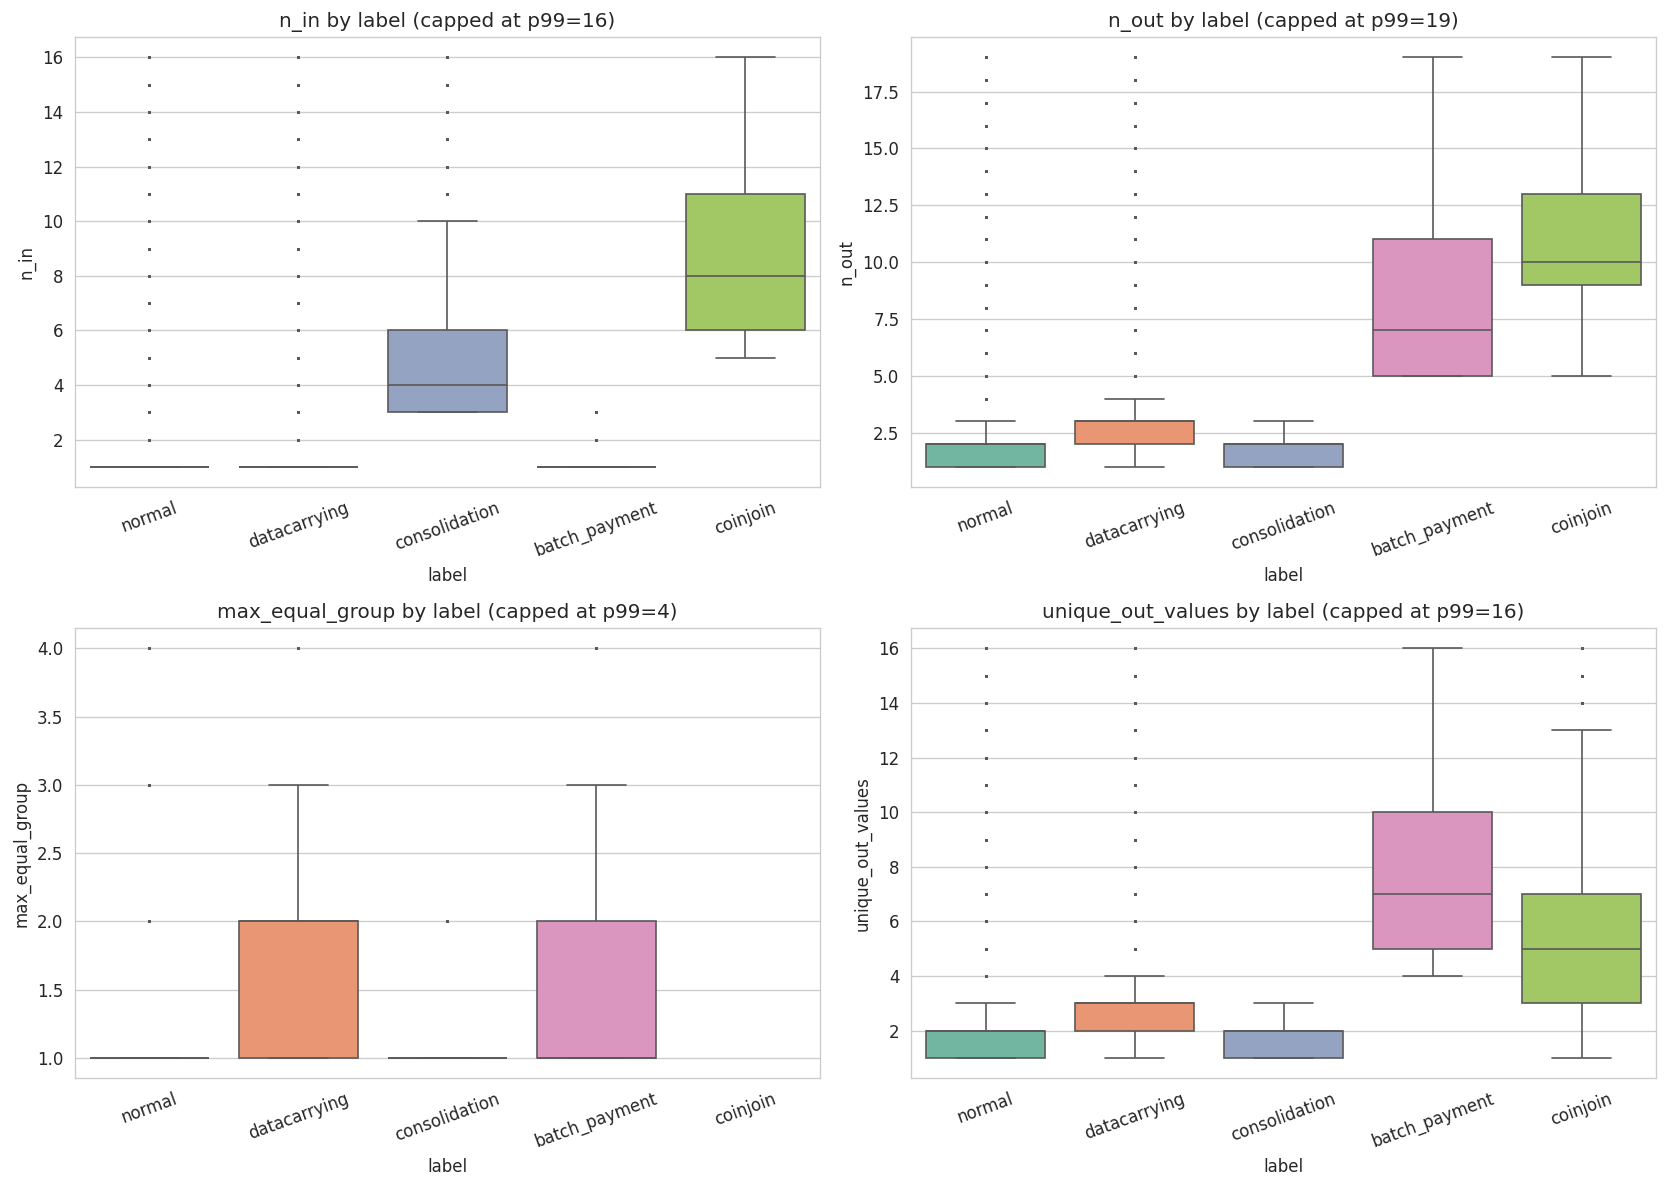

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

label_order = ["normal", "datacarrying", "consolidation", "batch_payment", "coinjoin"]

for ax, col in zip(axes.flat, struct_cols):
    cap = df[col].quantile(0.99)
    plot_data = df[df[col] <= cap]
    sns.boxplot(data=plot_data, x="label", y=col, order=label_order, ax=ax,
                palette="Set2", fliersize=0.3)
    ax.set_title(f"{col} by label (capped at p99={cap:.0f})")
    ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.savefig("plots/tx_annotation_structural_by_label.png", bbox_inches="tight")
plt.show()

## 5. Joint Distribution: n_in vs n_out by Label

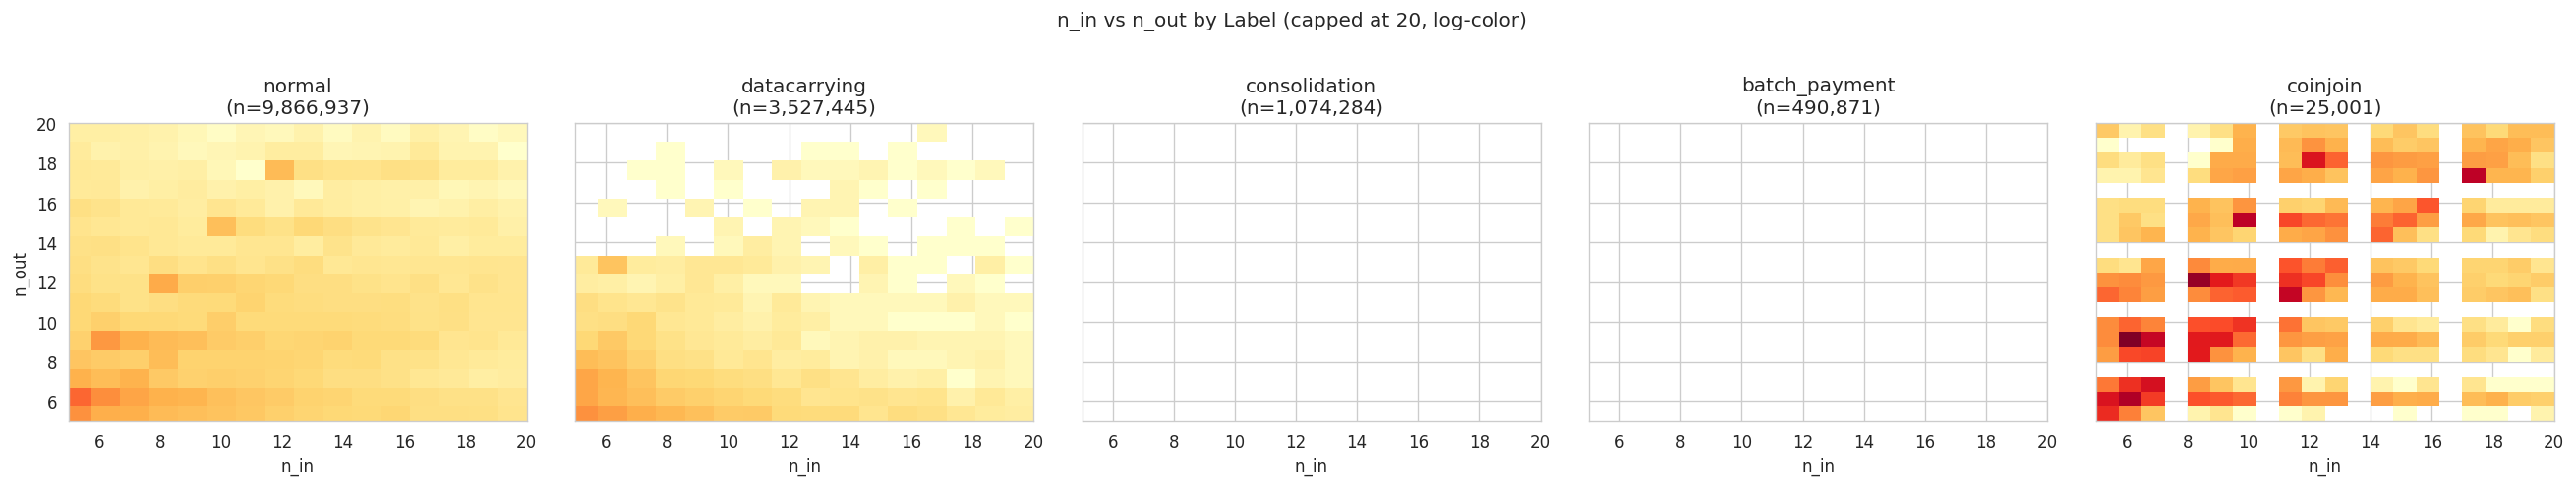

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(22, 4), sharex=True, sharey=True)

for ax, label in zip(axes, label_order):
    sub = df[df["label"] == label]
    sub_cap = sub[(sub["n_in"] <= 20) & (sub["n_out"] <= 20)]
    ax.hist2d(sub_cap["n_in"], sub_cap["n_out"], bins=20,
              cmap="YlOrRd", norm=plt.matplotlib.colors.LogNorm())
    ax.set_title(f"{label}\n(n={len(sub):,})")
    ax.set_xlabel("n_in")
    if ax == axes[0]:
        ax.set_ylabel("n_out")

plt.suptitle("n_in vs n_out by Label (capped at 20, log-color)", y=1.02)
plt.tight_layout()
plt.savefig("plots/tx_annotation_nin_nout_2d.png", bbox_inches="tight")
plt.show()

---
## 6. Merge with Original Data (Data-Lake DB)

The data-lake has the raw mempool data for these exact 15M transactions: timestamps, wait times, fees, weights, RBF info, mempool conditions, etc.

In [26]:
%%time
lake_conn = sqlite3.connect(LAKE_DB)
lake = pd.read_sql("""
    SELECT tx_id, found_at, mined_at, waittime, weight, size,
           fee_rate, absolute_fee, total_output_amount,
           mempool_tx_count, mempool_size,
           min_respend_blocks, rbf_fee_total, child_txid,
           conf_block_hash, version, seen_in_mempool
    FROM mempool_transactions
""", lake_conn)
lake_conn.close()
print(f"Data-lake shape: {lake.shape}")
lake.head(3)

Data-lake shape: (14984540, 17)
CPU times: user 1min 12s, sys: 36.7 s, total: 1min 49s
Wall time: 1min 53s


,tx_id,found_at,mined_at,waittime,weight,size,fee_rate,absolute_fee,total_output_amount,mempool_tx_count,mempool_size,min_respend_blocks,rbf_fee_total,child_txid,conf_block_hash,version,seen_in_mempool
0,30b076f9dfc66cc14b65f3643d22fb3a9a8db33d77de06...,2025-10-09 20:44:20,2025-10-09 20:45:02,42,1344,336,5.0,1745,166658,14048.861111,3.033024e+06,13,NaN,None,0000000000000000000111944224752fc334256f6642ec...,1,1
1,05f82c79dd8bb04522a7bd1dc3a56819f1cd204efd724d...,2025-10-09 20:44:19,2025-10-09 20:45:03,44,464,116,5.0,720,233381,14048.861111,3.033024e+06,8154,NaN,None,0000000000000000000111944224752fc334256f6642ec...,1,1
2,6bf5b94aafd57902fed8ead2b8065ec4cb577017b8677b...,2025-10-09 20:44:19,2025-10-09 20:45:00,41,452,113,6.0,846,21205790,14048.861111,3.033024e+06,12,NaN,None,0000000000000000000111944224752fc334256f6642ec...,1,1


In [27]:
lake.dtypes

tx_id                   object
found_at                object
mined_at                object
waittime                 int64
weight                   int64
size                     int64
fee_rate               float64
absolute_fee             int64
total_output_amount      int64
mempool_tx_count       float64
mempool_size           float64
min_respend_blocks       int64
rbf_fee_total          float64
child_txid              object
conf_block_hash         object
version                  int64
seen_in_mempool          int64
dtype: object

In [28]:
# Merge annotations with data-lake
merged = lake.merge(
    annot[["tx_id", "label", "tags", "n_in", "n_out",
           "max_equal_group", "unique_out_values",
           "has_op_return", "has_inscription"]],
    on="tx_id", how="inner"
)
print(f"Merged shape: {merged.shape}")
print(f"Lost rows: {len(lake) - len(merged):,}")
merged.head()

Merged shape: (14984540, 25)
Lost rows: 0


,tx_id,found_at,mined_at,waittime,weight,size,fee_rate,absolute_fee,total_output_amount,mempool_tx_count,...,version,seen_in_mempool,label,tags,n_in,n_out,max_equal_group,unique_out_values,has_op_return,has_inscription
0,30b076f9dfc66cc14b65f3643d22fb3a9a8db33d77de06...,2025-10-09 20:44:20,2025-10-09 20:45:02,42,1344,336,5.0,1745,166658,14048.861111,...,1,1,normal,[],2,1,1,1,False,False
1,05f82c79dd8bb04522a7bd1dc3a56819f1cd204efd724d...,2025-10-09 20:44:19,2025-10-09 20:45:03,44,464,116,5.0,720,233381,14048.861111,...,1,1,normal,[],1,2,1,2,False,False
2,6bf5b94aafd57902fed8ead2b8065ec4cb577017b8677b...,2025-10-09 20:44:19,2025-10-09 20:45:00,41,452,113,6.0,846,21205790,14048.861111,...,1,1,normal,[],1,2,1,2,False,False
3,dc6b93301e2776274cbe4b0f2a8475eefd215d742c790d...,2025-10-09 20:44:17,2025-10-09 20:45:01,44,452,113,5.0,804,81804,14048.861111,...,1,1,normal,[],1,2,1,2,False,False
4,1946bb8898f58d568b17a26de2df183e29afe7e878584c...,2025-10-09 20:44:17,2025-10-09 20:45:02,45,328,82,6.0,676,31867,14048.861111,...,1,1,normal,[],1,1,1,1,False,False


## 7. Also bring in corrected weights/fees from mempool.space

The mempool_space_data.db has API-fetched weight and fee_rate which may differ from the data-lake values.

In [29]:
%%time
ms_conn = sqlite3.connect(MEMPOOL_DB)
ms = pd.read_sql("""
    SELECT txid AS tx_id, weight AS ms_weight, fee AS ms_fee,
           fee_rate AS ms_fee_rate, vsize AS ms_vsize,
           block_height, block_time
    FROM transactions
""", ms_conn)
ms_conn.close()
print(f"mempool.space shape: {ms.shape}")
ms.head(3)

mempool.space shape: (19065494, 7)
CPU times: user 43.5 s, sys: 14.4 s, total: 58 s
Wall time: 1min 3s


,tx_id,ms_weight,ms_fee,ms_fee_rate,ms_vsize,block_height,block_time
0,9d9b74d8727f02e2472bff732fe915b2bec8c8e6fadcd6...,1404,0,0.000000,351,908486,1754270793
1,bffd0cd2686de4d2538a3f191a499a43d21bcdcc39adee...,1170,50000,171.232877,292,908486,1754270793
2,6be8073b37f81089b22f5fb7fee29c04900145c5659a80...,803,30300,151.500000,200,908486,1754270793


In [30]:
# Left join — keep all data-lake rows, add mempool.space columns where available
merged = merged.merge(ms, on="tx_id", how="left")
ms_matched = merged["ms_weight"].notna().sum()
print(f"Merged shape: {merged.shape}")
print(f"mempool.space match: {ms_matched:,} / {len(merged):,} ({ms_matched/len(merged)*100:.1f}%)")
merged.head()

Merged shape: (14984540, 31)
mempool.space match: 14,899,801 / 14,984,540 (99.4%)


,tx_id,found_at,mined_at,waittime,weight,size,fee_rate,absolute_fee,total_output_amount,mempool_tx_count,...,max_equal_group,unique_out_values,has_op_return,has_inscription,ms_weight,ms_fee,ms_fee_rate,ms_vsize,block_height,block_time
0,30b076f9dfc66cc14b65f3643d22fb3a9a8db33d77de06...,2025-10-09 20:44:20,2025-10-09 20:45:02,42,1344,336,5.0,1745,166658,14048.861111,...,1,1,False,False,1344.0,1745.0,5.193452,336.0,918353.0,1.760043e+09
1,05f82c79dd8bb04522a7bd1dc3a56819f1cd204efd724d...,2025-10-09 20:44:19,2025-10-09 20:45:03,44,464,116,5.0,720,233381,14048.861111,...,1,2,False,False,574.0,720.0,5.034965,143.0,918353.0,1.760043e+09
2,6bf5b94aafd57902fed8ead2b8065ec4cb577017b8677b...,2025-10-09 20:44:19,2025-10-09 20:45:00,41,452,113,6.0,846,21205790,14048.861111,...,1,2,False,False,561.0,846.0,6.042857,140.0,918353.0,1.760043e+09
3,dc6b93301e2776274cbe4b0f2a8475eefd215d742c790d...,2025-10-09 20:44:17,2025-10-09 20:45:01,44,452,113,5.0,804,81804,14048.861111,...,1,2,False,False,561.0,804.0,5.742857,140.0,918353.0,1.760043e+09
4,1946bb8898f58d568b17a26de2df183e29afe7e878584c...,2025-10-09 20:44:17,2025-10-09 20:45:02,45,328,82,6.0,676,31867,14048.861111,...,1,1,False,False,438.0,676.0,6.201835,109.0,918353.0,1.760043e+09


## 8. Compare Data-Lake vs Mempool.space: Weight & Fee Rate

How much do the corrected values differ from the originals?

In [31]:
has_both = merged.dropna(subset=["ms_weight"])
print(f"Rows with both sources: {len(has_both):,}")

# Weight comparison
has_both = has_both.copy()
has_both["weight_diff"] = has_both["ms_weight"] - has_both["weight"]
has_both["fee_rate_diff"] = has_both["ms_fee_rate"] - has_both["fee_rate"]

print("\nWeight difference (mempool.space - data-lake):")
print(has_both["weight_diff"].describe().round(2))
print(f"  Exact match: {(has_both['weight_diff'] == 0).sum():,} ({(has_both['weight_diff'] == 0).mean()*100:.1f}%)")
print(f"  Differ:      {(has_both['weight_diff'] != 0).sum():,}")

print("\nFee rate difference (mempool.space - data-lake):")
print(has_both["fee_rate_diff"].describe().round(4))
print(f"  Exact match: {(has_both['fee_rate_diff'] == 0).sum():,} ({(has_both['fee_rate_diff'] == 0).mean()*100:.1f}%)")

Rows with both sources: 14,899,801

Weight difference (mempool.space - data-lake):
count    14899801.00
mean          284.47
std          2821.96
min             0.00
25%           109.00
50%           110.00
75%           212.00
max        399391.00
Name: weight_diff, dtype: float64
  Exact match: 1,005,192 (6.7%)
  Differ:      13,894,609

Fee rate difference (mempool.space - data-lake):
count    1.489980e+07
mean     3.346000e-01
std      1.089340e+01
min     -4.692000e-01
25%      1.950000e-02
50%      1.676000e-01
75%      3.827000e-01
max      3.573536e+04
Name: fee_rate_diff, dtype: float64
  Exact match: 743,048 (5.0%)


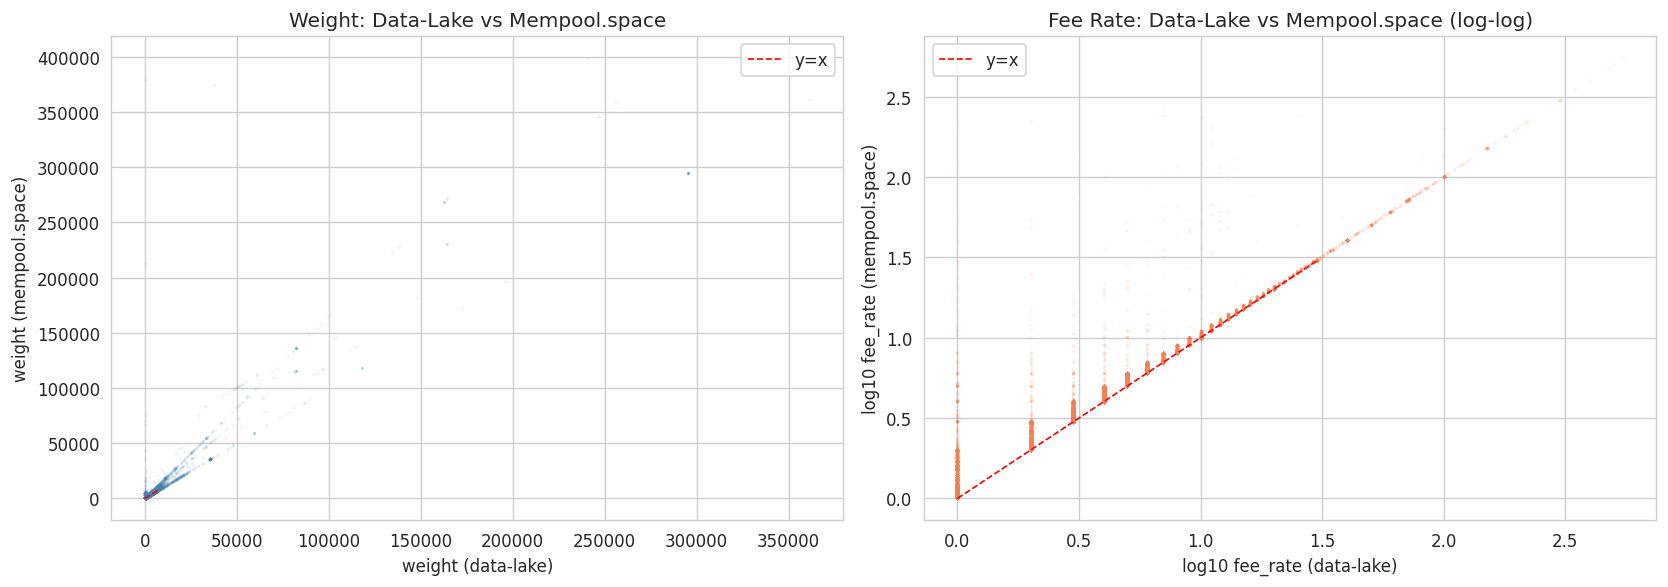

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Weight scatter (sample for speed)
samp = has_both.sample(min(len(has_both), 100_000), random_state=42)

axes[0].scatter(samp["weight"], samp["ms_weight"], alpha=0.05, s=1, color="steelblue")
lims = [0, samp[["weight", "ms_weight"]].quantile(0.99).max()]
axes[0].plot(lims, lims, "r--", linewidth=1, label="y=x")
axes[0].set_xlabel("weight (data-lake)")
axes[0].set_ylabel("weight (mempool.space)")
axes[0].set_title("Weight: Data-Lake vs Mempool.space")
axes[0].legend()

# Fee rate scatter
samp_pos = samp[(samp["fee_rate"] > 0) & (samp["ms_fee_rate"] > 0)]
axes[1].scatter(np.log10(samp_pos["fee_rate"]), np.log10(samp_pos["ms_fee_rate"]),
                alpha=0.05, s=1, color="coral")
lims = [np.log10(samp_pos[["fee_rate", "ms_fee_rate"]].quantile(0.01).min()),
        np.log10(samp_pos[["fee_rate", "ms_fee_rate"]].quantile(0.99).max())]
axes[1].plot(lims, lims, "r--", linewidth=1, label="y=x")
axes[1].set_xlabel("log10 fee_rate (data-lake)")
axes[1].set_ylabel("log10 fee_rate (mempool.space)")
axes[1].set_title("Fee Rate: Data-Lake vs Mempool.space (log-log)")
axes[1].legend()

plt.tight_layout()
plt.savefig("plots/tx_annotation_weight_feerate_comparison.png", bbox_inches="tight")
plt.show()

In [33]:
# Weight/fee discrepancy by label
disc = has_both.groupby("label").agg(
    n=("tx_id", "count"),
    weight_exact_match_pct=("weight_diff", lambda x: (x == 0).mean() * 100),
    weight_diff_median=("weight_diff", "median"),
    weight_diff_mean=("weight_diff", "mean"),
    feerate_exact_match_pct=("fee_rate_diff", lambda x: (x == 0).mean() * 100),
    feerate_diff_median=("fee_rate_diff", "median"),
).round(2)
disc

,n,weight_exact_match_pct,weight_diff_median,weight_diff_mean,feerate_exact_match_pct,feerate_diff_median
label,,,,,,
batch_payment,489328,4.20,109.0,145.48,1.57,0.16
coinjoin,24866,0.43,666.0,1106.45,2.97,0.06
consolidation,1070163,9.91,431.0,1663.73,3.78,0.07
datacarrying,3487888,1.86,212.0,303.24,5.58,0.28
error,2,0.00,142.5,142.50,0.00,0.35
normal,9827554,8.28,109.0,132.45,5.08,0.11


## 9. Fee & Wait-Time Distributions by Label

In [34]:
# Drop errors
m = merged[merged["label"] != "error"].copy()

fee_cols = ["fee_rate", "absolute_fee", "waittime", "total_output_amount"]
print("Medians by label:")
print(m.groupby("label")[fee_cols].median().round(2))
print("\nMeans by label:")
print(m.groupby("label")[fee_cols].mean().round(2))

Medians by label:
               fee_rate  absolute_fee  waittime  total_output_amount
label                                                               
batch_payment       3.0        1820.0     454.0           46878228.0
coinjoin            1.0        1867.0     483.0             690448.0
consolidation       2.0        1153.0     480.0            1039035.5
datacarrying        0.0          89.0     950.0              61567.0
normal              2.0         429.0     473.0             276911.0

Means by label:
               fee_rate  absolute_fee  waittime  total_output_amount
label                                                               
batch_payment      4.41       2745.07    756.68         8.651011e+08
coinjoin           2.57       4332.46   1162.91         2.123232e+08
consolidation      3.55       4757.61   1207.39         4.622330e+08
datacarrying       0.85        274.03  10607.94         7.896790e+07
normal             4.09        743.09   1112.45         1.485668e+08

/tmp/ipykernel_183796/1026926932.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = m.groupby("label", group_keys=False).apply(
/tmp/ipykernel_183796/1026926932.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=s, x="label", y=plot_col, order=label_order,
/tmp/ipykernel_183796/1026926932.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=s, x="label", y=plot_col, order=label

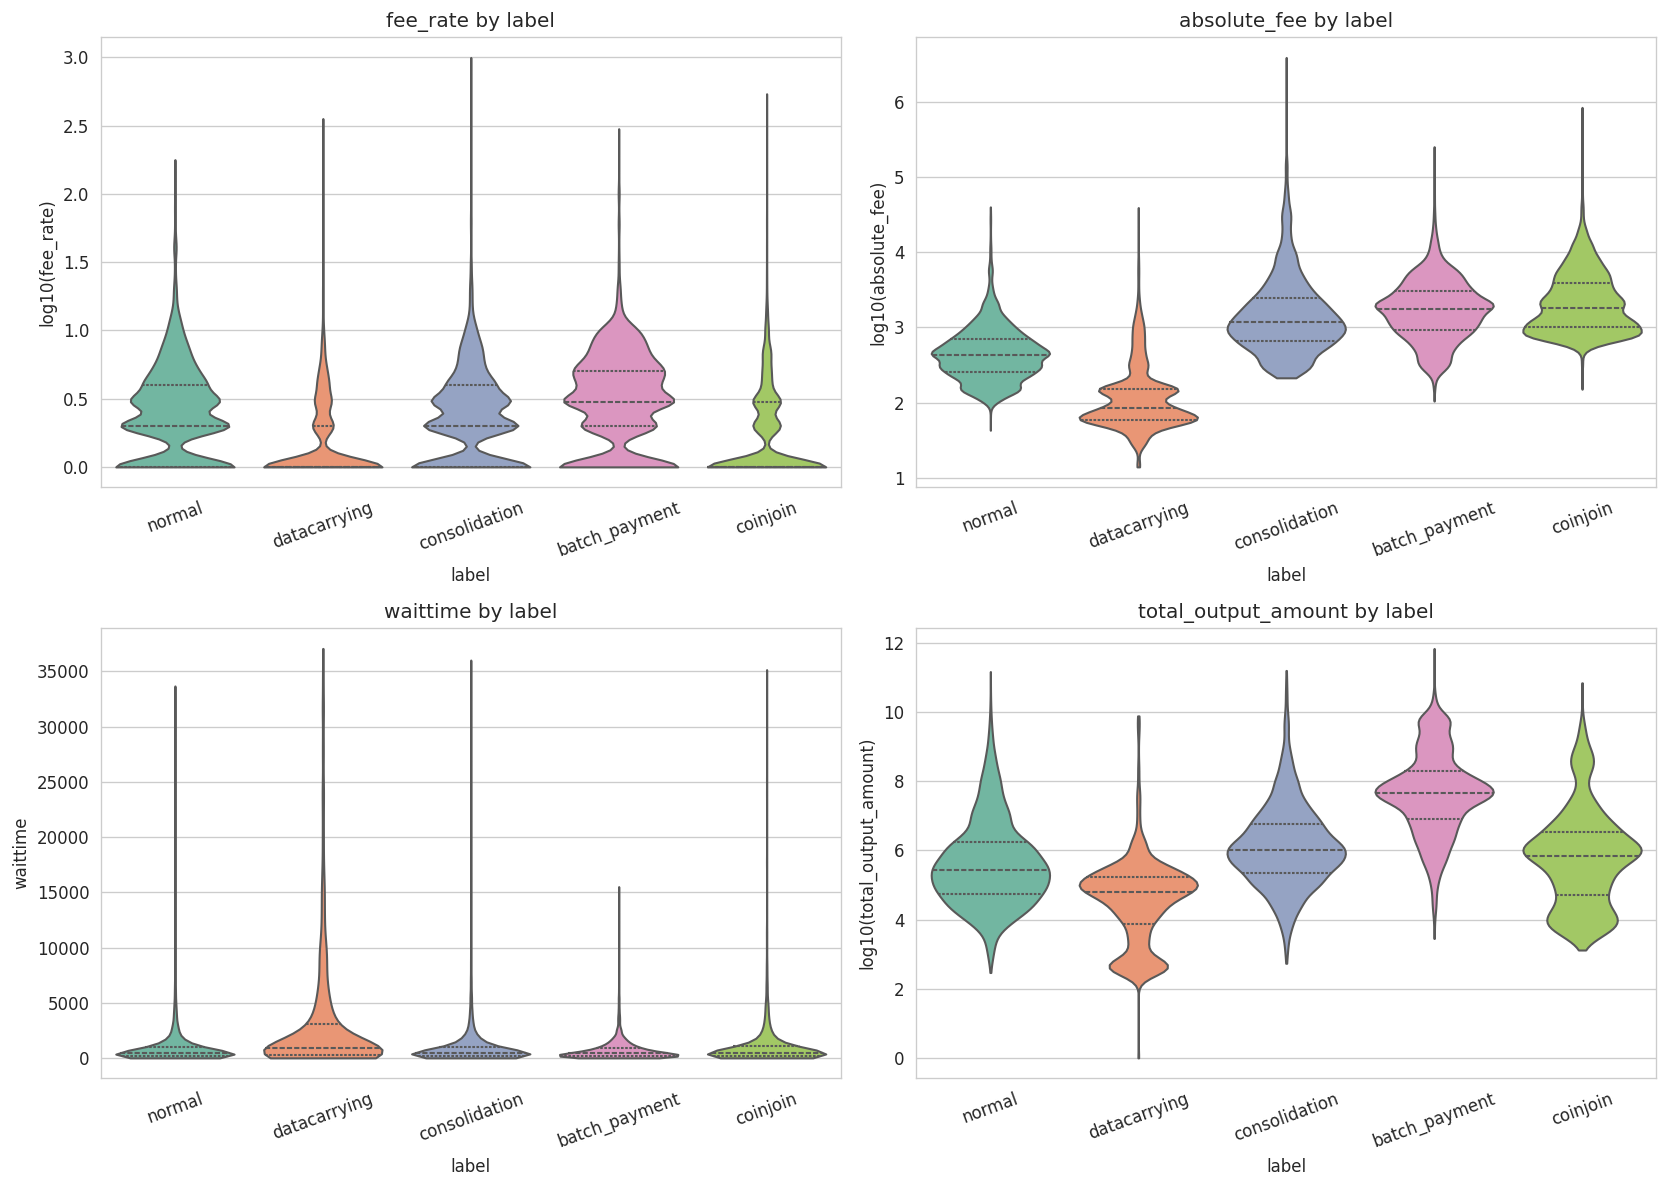

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sample for violin plots
sample = m.groupby("label", group_keys=False).apply(
    lambda g: g.sample(min(len(g), 5000), random_state=42)
)

for ax, col in zip(axes.flat, fee_cols):
    s = sample.copy()
    # Use log scale for skewed columns
    if col in ["fee_rate", "absolute_fee", "total_output_amount"]:
        s = s[s[col] > 0].copy()
        s[f"log_{col}"] = np.log10(s[col])
        plot_col = f"log_{col}"
        ylabel = f"log10({col})"
    else:
        lo, hi = s[col].quantile(0.01), s[col].quantile(0.99)
        s = s[(s[col] >= lo) & (s[col] <= hi)]
        plot_col = col
        ylabel = col
    
    sns.violinplot(data=s, x="label", y=plot_col, order=label_order,
                   ax=ax, palette="Set2", inner="quartile", cut=0)
    ax.set_title(f"{col} by label")
    ax.set_ylabel(ylabel)
    ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.savefig("plots/tx_annotation_fee_waittime_by_label.png", bbox_inches="tight")
plt.show()

## 10. Mempool Congestion at Time of Broadcast by Label

Do different tx types tend to be broadcast under different congestion regimes?

In [36]:
congestion_cols = ["mempool_tx_count", "mempool_size"]
print("Medians by label:")
print(m.groupby("label")[congestion_cols].median().round(0))
print("\nMeans by label:")
print(m.groupby("label")[congestion_cols].mean().round(0))

Medians by label:
               mempool_tx_count  mempool_size
label                                        
batch_payment            7287.0     3263803.0
coinjoin                53644.0    17424975.0
consolidation            6964.0     2902704.0
datacarrying            60571.0    19407877.0
normal                  10442.0     5933646.0

Means by label:
               mempool_tx_count  mempool_size
label                                        
batch_payment           34220.0    10734995.0
coinjoin                43601.0    13108117.0
consolidation           33926.0    10534561.0
datacarrying            52954.0    16709049.0
normal                  37968.0    11421365.0


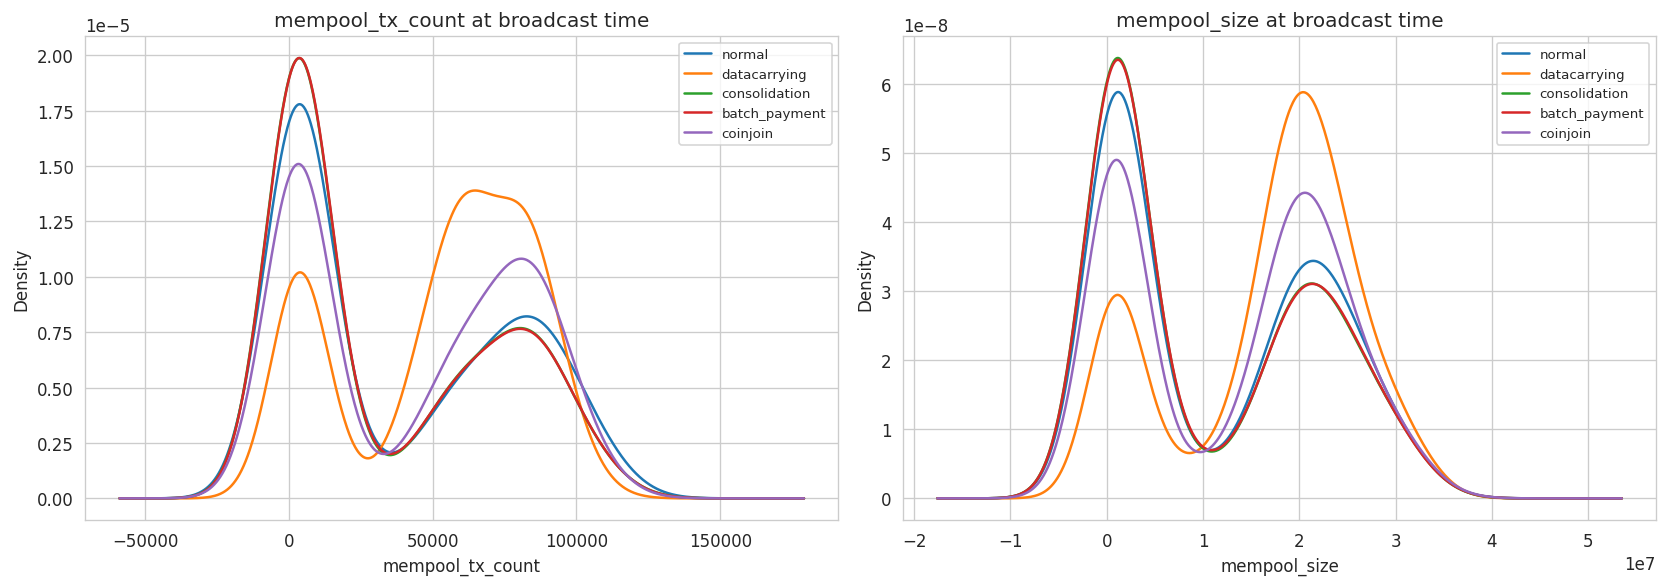

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col in zip(axes, congestion_cols):
    for label in label_order:
        sub = m[m["label"] == label][col].dropna()
        sub = sub.sample(min(len(sub), 50_000), random_state=42)
        sub.plot.kde(ax=ax, label=f"{label}", bw_method=0.3)
    ax.set_title(f"{col} at broadcast time")
    ax.set_xlabel(col)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## 11. RBF & CPFP Behavior by Label

Do certain transaction types use fee-bumping more often?

In [38]:
m["has_rbf"] = m["rbf_fee_total"].notna() & (m["rbf_fee_total"] > 0)
m["has_cpfp"] = m["child_txid"].notna() & (m["child_txid"] != "")

rbf_cpfp = m.groupby("label").agg(
    n=("tx_id", "count"),
    rbf_pct=("has_rbf", lambda x: x.mean() * 100),
    cpfp_pct=("has_cpfp", lambda x: x.mean() * 100),
    median_min_respend=("min_respend_blocks", "median"),
).round(2)
rbf_cpfp

,n,rbf_pct,cpfp_pct,median_min_respend
label,,,,
batch_payment,490871,2.24,28.37,3.0
coinjoin,25001,0.04,12.67,1.0
consolidation,1074284,0.23,6.17,12.0
datacarrying,3527445,1.23,70.28,0.0
normal,9866937,0.70,14.03,7.0


## 12. Output Amount Distribution by Label

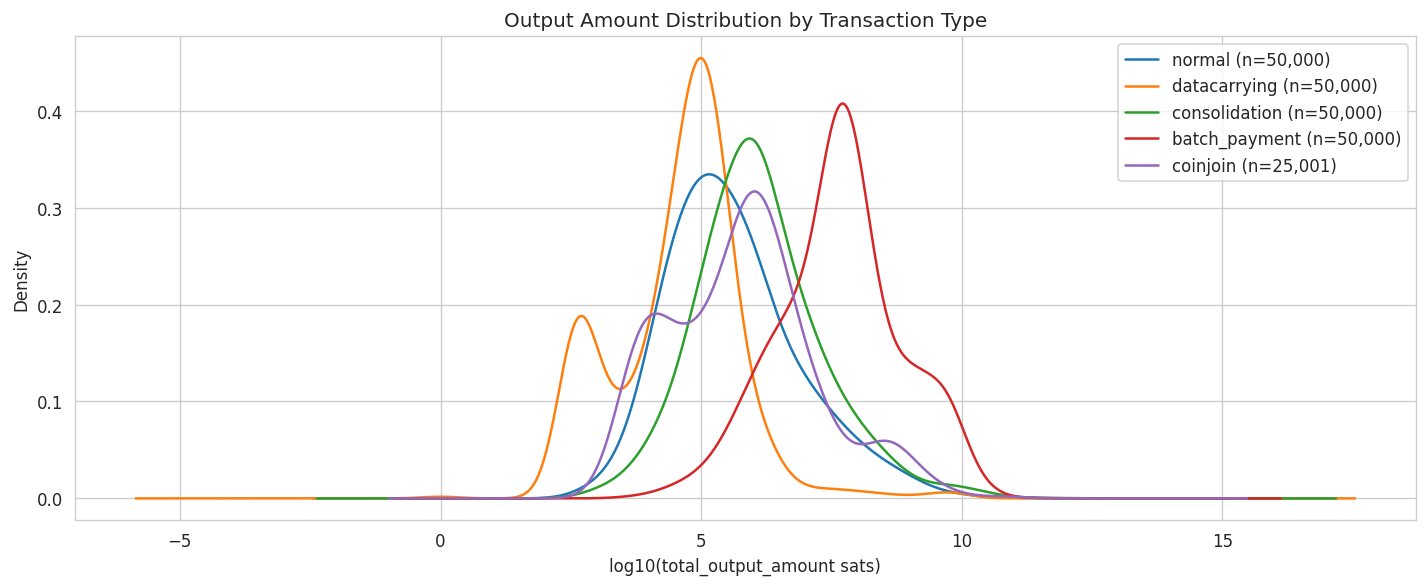

In [39]:
fig, ax = plt.subplots(figsize=(12, 5))

for label in label_order:
    sub = m[m["label"] == label]["total_output_amount"]
    sub = sub[sub > 0]
    sub = sub.sample(min(len(sub), 50_000), random_state=42)
    np.log10(sub).plot.kde(ax=ax, label=f"{label} (n={len(sub):,})", bw_method=0.3)

ax.set_xlabel("log10(total_output_amount sats)")
ax.set_title("Output Amount Distribution by Transaction Type")
ax.legend()
plt.tight_layout()
plt.savefig("plots/tx_annotation_output_amount_kde.png", bbox_inches="tight")
plt.show()

## 13. CoinJoin Deep Dive

In [40]:
cj = m[m["label"] == "coinjoin"]
print(f"CoinJoin transactions: {len(cj):,}")
print(f"\nStructural stats:")
print(cj[["n_in", "n_out", "max_equal_group", "unique_out_values"]].describe().round(1))
print(f"\nFee & timing:")
print(cj[["fee_rate", "absolute_fee", "waittime", "total_output_amount"]].describe().round(2))

CoinJoin transactions: 25,001

Structural stats:
          n_in    n_out  max_equal_group  unique_out_values
count  25001.0  25001.0          25001.0            25001.0
mean      13.9     15.7             10.9                5.3
std       25.0     29.4             25.7                3.2
min        5.0      5.0              5.0                1.0
25%        7.0      9.0              5.0                3.0
50%        9.0     12.0              7.0                5.0
75%       15.0     17.0             10.0                7.0
max     1465.0   1002.0            977.0              159.0

Fee & timing:
       fee_rate  absolute_fee   waittime  total_output_amount
count  25001.00      25001.00   25001.00         2.500100e+04
mean       2.57       4332.46    1162.91         2.123232e+08
std        6.59      15373.14    3228.90         3.521678e+09
min        0.00        151.00       1.00         1.320000e+03
25%        1.00       1010.00     208.00         4.798200e+04
50%        1.00       18

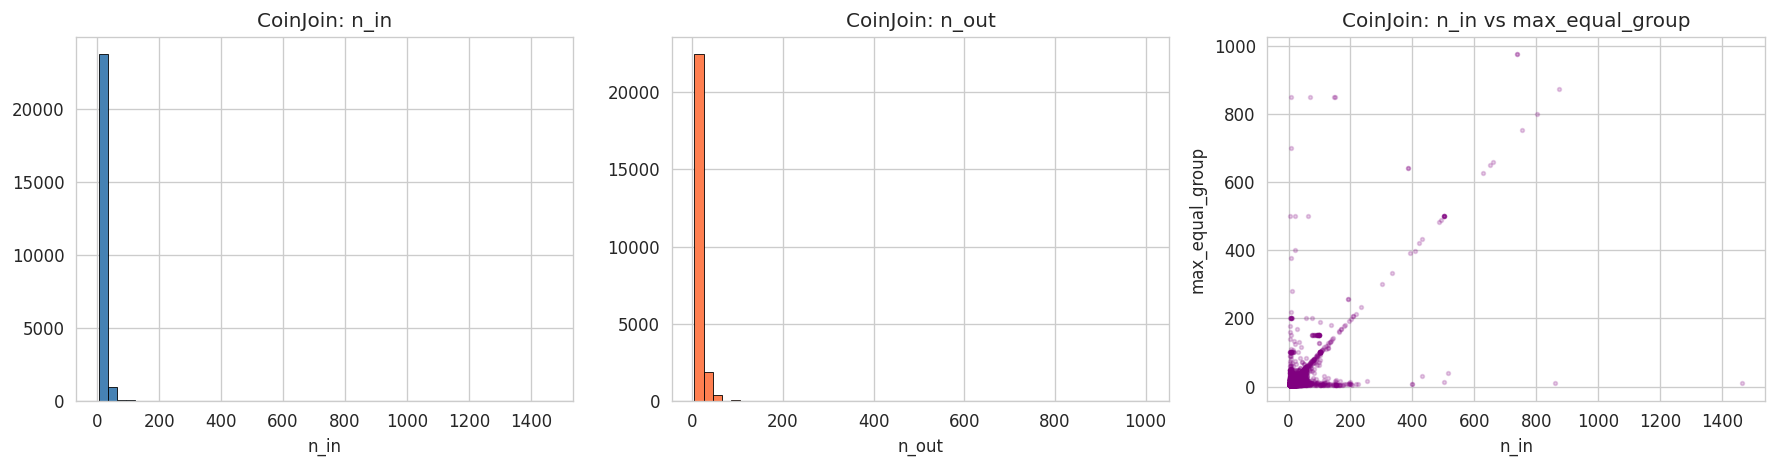

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(cj["n_in"], bins=50, color="steelblue", edgecolor="black", linewidth=0.5)
axes[0].set_title("CoinJoin: n_in")
axes[0].set_xlabel("n_in")

axes[1].hist(cj["n_out"], bins=50, color="coral", edgecolor="black", linewidth=0.5)
axes[1].set_title("CoinJoin: n_out")
axes[1].set_xlabel("n_out")

axes[2].scatter(cj["n_in"], cj["max_equal_group"], alpha=0.2, s=5, color="purple")
axes[2].set_title("CoinJoin: n_in vs max_equal_group")
axes[2].set_xlabel("n_in")
axes[2].set_ylabel("max_equal_group")

plt.tight_layout()
plt.show()

## 14. Inscription / OP_RETURN vs Normal: Fee Behavior

In [42]:
print(f"Inscriptions: {m['has_inscription'].sum():,} ({m['has_inscription'].mean()*100:.1f}%)")
print(f"OP_RETURN:    {m['has_op_return'].sum():,} ({m['has_op_return'].mean()*100:.1f}%)")
print(f"Both:         {(m['has_inscription'] & m['has_op_return']).sum():,}")
print()

compare_cols = ["fee_rate", "absolute_fee", "waittime", "weight", "total_output_amount"]
comparison = pd.DataFrame({
    "normal_median": m.loc[m["label"] == "normal", compare_cols].median(),
    "inscription_median": m.loc[m["has_inscription"], compare_cols].median(),
    "datacarrying_median": m.loc[m["label"] == "datacarrying", compare_cols].median(),
}).round(2)
comparison["insc_vs_normal"] = (comparison["inscription_median"] / comparison["normal_median"]).round(2)
comparison

Inscriptions: 2,282,446 (15.2%)
OP_RETURN:    3,001,626 (20.0%)
Both:         1,698,311



,normal_median,inscription_median,datacarrying_median,insc_vs_normal
fee_rate,2.0,0.0,0.0,0.00
absolute_fee,429.0,78.0,89.0,0.18
waittime,473.0,1262.0,950.0,2.67
weight,464.0,572.0,572.0,1.23
total_output_amount,276911.0,56756.0,61567.0,0.20


## 15. Summary Table

In [43]:
summary = m.groupby("label").agg(
    count=("tx_id", "count"),
    pct=("tx_id", lambda x: len(x) / len(m) * 100),
    median_fee_rate=("fee_rate", "median"),
    median_abs_fee=("absolute_fee", "median"),
    median_waittime=("waittime", "median"),
    median_weight=("weight", "median"),
    median_n_in=("n_in", "median"),
    median_n_out=("n_out", "median"),
    median_output_amt=("total_output_amount", "median"),
    rbf_pct=("has_rbf", lambda x: x.mean() * 100),
    cpfp_pct=("has_cpfp", lambda x: x.mean() * 100),
).round(2)
summary["pct"] = summary["pct"].round(1)
summary

,count,pct,median_fee_rate,median_abs_fee,median_waittime,median_weight,median_n_in,median_n_out,median_output_amt,rbf_pct,cpfp_pct
label,,,,,,,,,,,
batch_payment,490871,3.3,3.0,1820.0,454.0,1508.0,1.0,10.0,46878228.0,2.24,28.37
coinjoin,25001,0.2,1.0,1867.0,483.0,3416.0,9.0,12.0,690448.0,0.04,12.67
consolidation,1074284,7.2,2.0,1153.0,480.0,1108.0,4.0,2.0,1039035.5,0.23,6.17
datacarrying,3527445,23.5,0.0,89.0,950.0,572.0,1.0,3.0,61567.0,1.23,70.28
normal,9866937,65.8,2.0,429.0,473.0,464.0,1.0,2.0,276911.0,0.70,14.03


## 16. Implications for Fee Model

Key questions for Stage 3:
1. Should `label` be a **control variable** in the fee equation?
2. Do different tx types have **different impatience-fee relationships** (interaction effects)?
3. Should we **filter out** datacarrying/inscription txs that may follow different fee logic?
4. How much does the corrected weight/fee_rate from mempool.space change results?

In [44]:
# Correlation of label/tag dummies with fee_rate
label_dummies = pd.get_dummies(m["label"], prefix="label", drop_first=True)
tag_dummies = m[["has_op_return", "has_inscription"]].astype(int)
all_dummies = pd.concat([label_dummies, tag_dummies], axis=1)

for target in ["fee_rate", "waittime", "absolute_fee"]:
    corrs = all_dummies.corrwith(m[target]).sort_values()
    print(f"\nCorrelations with {target}:")
    print(corrs.round(4))


Correlations with fee_rate:
label_datacarrying    -0.1231
has_op_return         -0.1176
has_inscription       -0.1047
label_coinjoin        -0.0027
label_consolidation    0.0066
label_normal           0.0998
dtype: float64

Correlations with waittime:
label_normal          -0.1037
label_consolidation   -0.0199
label_coinjoin        -0.0030
has_inscription        0.0610
label_datacarrying     0.1349
has_op_return          0.1464
dtype: float64

Correlations with absolute_fee:
label_datacarrying    -0.0311
has_op_return         -0.0294
label_normal          -0.0270
has_inscription       -0.0126
label_coinjoin         0.0107
label_consolidation    0.0817
dtype: float64
